In [3]:
%matplotlib inline  
import matplotlib.pyplot as plt
import csv
# Numpy
import numpy as np
from numpy import exp, log, minimum, sqrt
import math
# Scipy
from scipy import optimize
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import scipy

from os import listdir
from os.path import isfile, join
from astropy.io import fits
import galsim
from IPython.display import clear_output

from numpy import mgrid, sum
import scipy.linalg as alg
import scipy.stats as stats


In [108]:
class shapeletXmoment:
    
    def __init__(self, psf,n, bmax = 10, pixel_scale = 1.0):
        self.n = n
        self.bmax = bmax
        self.pixel_scale = pixel_scale
        self.base_psf = psf
        self.base_psf_image = psf.drawImage(scale = pixel_scale, method = 'no_pixel')
        self.base_psf_result = galsim.hsm.FindAdaptiveMom(self.base_psf_image)
        self.base_shapelet = galsim.Shapelet.fit(self.base_psf_result.moments_sigma, bmax, self.base_psf_image, normalization = 'sb')
        self.base_bvec = self.base_shapelet.bvec
        
    def moment_measure(self, image, p, q,results):
        n = p+q
        
        if n<2:
            print "Does not support moment measure less than second order."
            return 0
        elif n==2:
            return self.get_second_moment(image,p,q,results)
        else:
            return self.higher_weighted_moment(image,p,q,results)
        
    def get_second_moment(self, image, p ,q,results):
        image_results = results
        if p==2:
            return image_results.observed_shape.e1
        elif q==2:
            return image_results.observed_shape.e2
        else:
            return image_results.moments_sigma
        
    def higher_weighted_moment(self,gsimage,p,q,results):
                
        image = gsimage.array

        y, x = mgrid[:image.shape[0],:image.shape[1]]+1
        
        
        psfresults = results
        M = np.zeros((2,2))
        e1 = psfresults.observed_shape.e1
        e2 = psfresults.observed_shape.e2
        sigma4 = psfresults.moments_sigma**4
        c = (1+e1)/(1-e1)
        M[1][1] = np.sqrt(sigma4/(c-0.25*e2**2*(1+c)**2))
        M[0][0] = c*M[1][1]
        M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
        M[1][0] = M[0][1]
        


        pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
        pos = np.swapaxes(pos,0,1)
        pos = np.swapaxes(pos,1,2)
        
        
        pos_x = pos[:,:,0]
        pos_y = pos[:,:,1]
        
#         plt.imshow(pos_x,cmap = 'RdBu', vmin = -12, vmax = 12)
#         plt.show()
        
#         plt.imshow(pos_y,cmap = 'RdBu', vmin = -12, vmax = 12)
#         plt.show()


        inv_M = np.linalg.inv(M)
        sqrt_inv_M = alg.sqrtm(inv_M)
        std_pos = np.zeros(pos.shape)
        weight = np.zeros(pos.shape[0:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                this_pos = pos[i][j]
                this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
                std_pos[i][j] = this_standard_pos
                weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))

        std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]
        

        
#         plt.imshow(std_x,cmap = 'RdBu', vmin = -12, vmax = 12)
#         plt.colorbar()
#         plt.show()
#         plt.imshow(std_y,cmap = 'RdBu', vmin = -12, vmax = 12)
#         plt.colorbar()
#         plt.show()

        return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    def modify_pq(self, m, c, delta = 0.0001):
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)

        ori_moments = self.get_all_moments(self.base_psf_image, pq_list)
        
        A = np.zeros(shape =(mu, mu))
        
        #i is the mode index
        #j is the moment index
        #measure d_moment_j / d_mode_i
        
        for i in range(mu):
            
            mode_index = shapelet_list[i]
            
            pert_bvec = self.base_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale,method = 'no_pixel'), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - ori_moments[j])/delta     
        self.A = A


        dm = np.zeros(mu)
        dm += m*ori_moments + c
        ds = np.linalg.solve(A.T,dm)
        #print ds
        #print dm
        
        true_mod_bvec = self.base_bvec.copy()
        for i in range(mu):
            true_mod_bvec[shapelet_list[i]]+=ds[i]

        
        self.true_mod = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, true_mod_bvec)
        return self.true_mod
            

                
    def get_all_moments(self, image, pq_list):
        quick_results = galsim.hsm.FindAdaptiveMom(image)
        results_list = []
        for tup in pq_list:
            results_list.append(self.moment_measure(image, tup[0], tup[1],quick_results))
                
        return np.array(results_list)
        
        
    def pq2mode(self,p,q):
        
        if p<=q:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)
        else:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)+1
        
        
        
    def pq2shapelet(self,pq_list):
        shapelet_index = []
        for tup in pq_list:
            shapelet_index.append(self.pq2mode(tup[0], tup[1]))
        return shapelet_index
        
        
        

        
        
    def get_mu(self, n):
        
        mu = 0
        for i in range(2,n+1):
            mu+=i+1
        return mu
    
    def get_pq_full(self,nmax):
        
        pq_list = []
        
        for n in range(2, nmax+1):
            p = 0
            q = n
            
            pq_list.append((p,q))
            
            while p<n:
                p+=1
                q-=1
                pq_list.append((p,q))
        return pq_list
    
    def get_pq_except(self,nmax,p,q):
        
        pq_full = self.get_pq_full(nmax)
        pq_except = []
        for tup in pq_full:
            if tup != (p,q):
                pq_except.append(tup)
                
        return pq_except
     
        

In [110]:
psf = galsim.Gaussian(sigma = 1.0)
pqlist = sxm.get_pq_full(6)
moments_measure = np.zeros(shape = (11,25))
for i in range(11):
    psf_tilt = psf.shear(g1 = -0.05+0.01*i,g2 = 0.0 )
    image = psf_tilt.drawImage(scale = 0.1, method = 'no_pixel')
    moments = sxm.get_all_moments(image, pqlist)
    moments_measure[i] = moments
    print moments.shape

(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)


In [111]:
moments_measure[:,2]

array([-9.97506231e-02, -7.98721984e-02, -5.99460490e-02, -3.99840027e-02,
       -1.99979991e-02, -1.98951967e-15,  1.99979991e-02,  3.99840027e-02,
        5.99460490e-02,  7.98721984e-02,  9.97506231e-02])

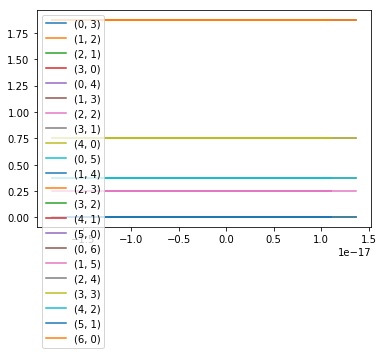

In [112]:
for i in range(3,25):
    pq = pqlist[i]
    plt.plot(moments_measure[:,0],moments_measure[:,i],label = str(pq))
plt.legend()

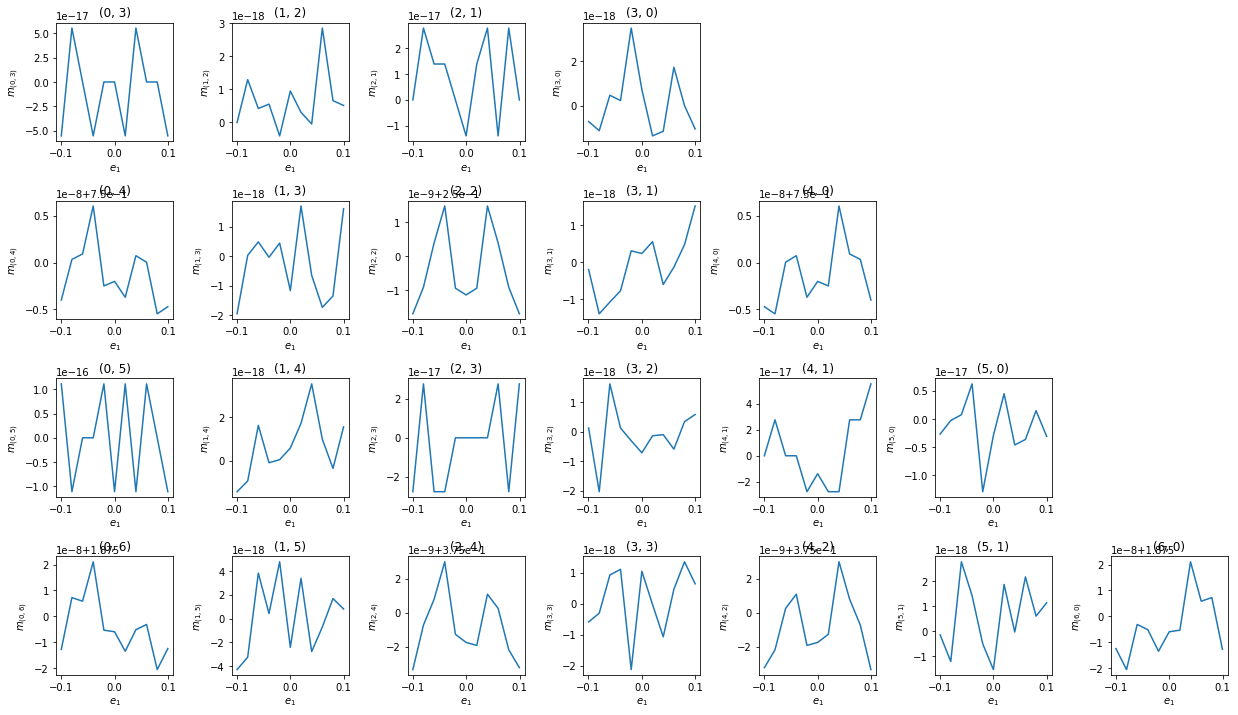

In [113]:
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)


for j in range(3,25):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    
    
    plt.plot(moments_measure[:,2],moments_measure[:,j])


    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    plt.xlabel(r"$ e_1$")
    plt.ylabel(r'$m_{'+str((p,q))+'}$')
    
    
    
    plt.title(str((p,q)))
    #plt.show()
    #plt.legend()
    
#fig.colorbar(axes)

In [114]:
psf = galsim.Gaussian(sigma = 1.0)
pqlist = sxm.get_pq_full(6)
moments_measure = np.zeros(shape = (11,25))
for i in range(11):
    psf_tilt = psf.shear(g1 = 0.0 ,g2 = -0.05+0.01*i)
    image = psf_tilt.drawImage(scale = 0.1, method = 'no_pixel')
    moments = sxm.get_all_moments(image, pqlist)
    moments_measure[i] = moments
    print moments.shape

(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)
(25,)


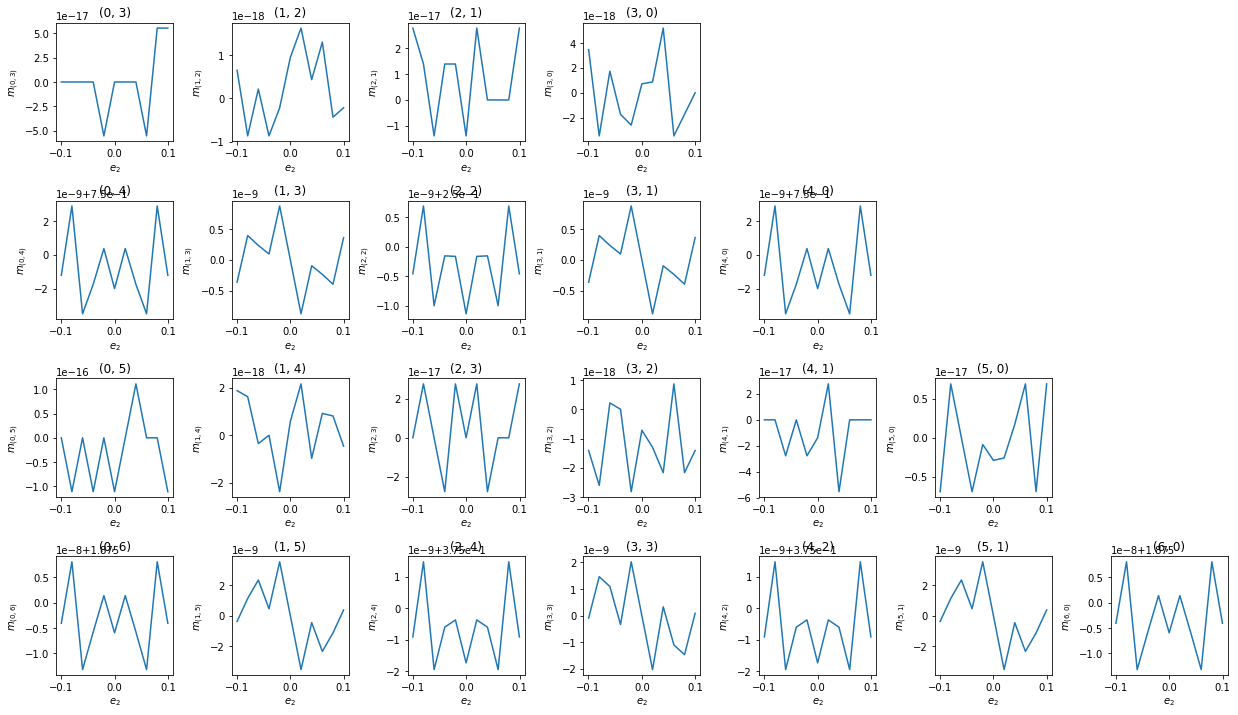

In [115]:
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)


for j in range(3,25):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    
    
    plt.plot(moments_measure[:,0],moments_measure[:,j])


    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    plt.xlabel(r"$ e_2$")
    plt.ylabel(r'$m_{'+str((p,q))+'}$')
    
    
    
    plt.title(str((p,q)))
    #plt.show()
    #plt.legend()
    
#fig.colorbar(axes)

In [103]:
psf = galsim.Gaussian(sigma = 5.0)
psf = psf.shear(e1 = 0.0, e2 = -0.05)
image = psf.drawImage(scale = 1.0, method = 'no_pixel')
moments = sxm.get_all_moments(image, pqlist)

In [106]:
psfresults = galsim.hsm.FindAdaptiveMom(image)
M = np.zeros((2,2))
e1 = psfresults.observed_shape.e1
e2 = psfresults.observed_shape.e2
sigma4 = psfresults.moments_sigma**4
c = (1+e1)/(1-e1)
M[1][1] = np.sqrt(sigma4/(c-0.25*e2**2*(1+c)**2))
M[0][0] = c*M[1][1]
M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
M[1][0] = M[0][1]

In [107]:
e2 = 2*M[0][1]/ (M[0][0] + M[1][1])
e1 = (M[0][0] - M[1][1])/ (M[0][0] + M[1][1])
sigma = (M[0][0] * M[1][1] - M[0][1]**2)**0.25
#sigma = M[0][0] +  M[1][1]
moment_sigma = psfresults.moments_sigma

print M
#print (e2-0.05)/0.05
#print e1
print sigma
print moment_sigma
print psfresults

[[25.03130871 -1.25156527]
 [-1.25156527 25.03130871]]
5.0
5.0
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=62, ymin=1, ymax=62), moments_status=0L, observed_shape=galsim.Shear(-0.025015641202760265j), moments_sigma=5.0, moments_amp=1.0, moments_centroid=galsim.PositionD(x=31.5, y=31.5), moments_rho4=1.9999999866803733, moments_n_iter=4L, correction_status=-10L)


In [91]:
M[0][0] * M[1][1]

1.4880948484603076

In [24]:
print moments

[ 9.94205475e-02  5.00837803e+00  2.80128010e-09  1.25241106e-09
 -2.43978662e-10 -1.31654033e-09  2.27843527e-08  7.14883263e-01
  4.42084276e-08  2.38294695e-01  4.25014492e-08  7.14883269e-01
  8.22032754e-09 -1.98719392e-09 -1.21812183e-09  1.07992858e-08
 -5.73801224e-09  1.43426922e-07  1.74486455e+00  2.11467849e-07
  3.48973707e-01  1.21001775e-07  3.48973711e-01  2.02987762e-07
  1.74486459e+00]


In [4]:
catalog = pd.read_csv("six_noblend_nosat_nosuspect_file_matching_quality_check.csv",header = 0)

In [7]:
catalog = catalog[catalog['bad']==True]

In [5]:
catalog.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', '# object_id',
       'parent_id', 'ira', 'idec', 'imag_psf', 'imag_psf_err', 'iflux_psf',
       'iflux_psf_err', 'iflux_psf_flags', 'ishape_sdss_ixx',
       'ishape_sdss_iyy', 'ishape_sdss_ixy', 'ishape_sdss_ixx_var',
       'ishape_sdss_iyy_var', 'ishape_sdss_ixy_var', 'ishape_sdss_psf_ixx',
       'ishape_sdss_psf_iyy', 'ishape_sdss_psf_ixy', 'tract',
       'icalib_psf_used', 'merge_peak_g', 'merge_peak_r', 'merge_peak_i',
       'merge_peak_z', 'merge_peak_y', 'icountinputs',
       'ideblend_has_stray_flux', 'iflags_pixel_bright_object_center',
       'iflags_pixel_bright_object_any', 'iblendedness_abs_flux',
       'iflags_negative', 'ideblend_too_many_peaks', 'ideblend_parent_too_big',
       'icentroid_naive_flags', 'iflags_pixel_interpolated_any',
       'iflags_pixel_saturated_any', 'iflags_pixel_cr_any',
       'iflags_pixel_suspect_any', 'SNR', 'logSNR', 'psf_filename',
       'star_filename', 'bad'],
      dtype='ob

In [8]:
catalog.shape

(0, 46)

In [118]:
psf = galsim.Gaussian(5.0)
sxm = shapeletXmoment(psf,4)

In [119]:
pqlist = sxm.get_pq_full(6)
for tup in pqlist:
    column_name = "model_moment"+str(tup[0])+str(tup[1])
    catalog[column_name] = -10.0

In [120]:
for i in range(catalog.shape[0]):
    #print i
    filename = catalog['psf_filename'][i]
    hdul = fits.open(filename)
    data = hdul[0].data
    PSFImage = galsim.Image(data)
    moments = sxm.get_all_moments(PSFImage, pqlist)
    for j in range(len(moments)):
        column_name = "model_moment"+str(pqlist[j][0])+str(pqlist[j][1])
        catalog.at[i,column_name] = moments[j]
    if i%1000==0:
        print i

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [121]:
pqlist = sxm.get_pq_full(6)
for tup in pqlist:
    column_name = "star_moment"+str(tup[0])+str(tup[1])
    catalog[column_name] = -10.0

In [122]:
for i in range(catalog.shape[0]):
    #print i
    filename = catalog['star_filename'][i]
    hdul = fits.open(filename)
    data = hdul[1].data
    PSFImage = galsim.Image(data)
    try:
        moments = sxm.get_all_moments(PSFImage, pqlist)
    except :
        continue
    
    for j in range(len(moments)):
        column_name = "star_moment"+str(pqlist[j][0])+str(pqlist[j][1])
        catalog.at[i,column_name] = moments[j]
    if i%1000==0:
        print i

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [124]:
catalog.to_csv(r'HSC_higher_moments_all_six.csv')


In [264]:
print pqlist

[(0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]


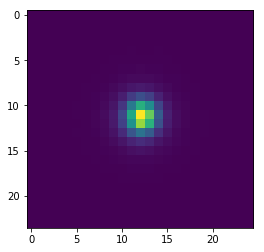

In [15]:
test_image = fits.open(catalog['star_filename'][40])[1].data 
test_PSFImage = galsim.Image(test_image,scale = 1.0)
plt.imshow(test_image)

In [16]:
test_moments = sxm.get_all_moments(test_PSFImage, pqlist)
print test_moments

(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
[-9.99368448e-03  1.30423033e+00 -7.83401728e-02  1.36998114e-03
 -5.86749205e-03 -2.48642973e-04 -6.54271779e-03  8.04834109e-01
  8.12554769e-04  2.70905902e-01 -1.09703907e-03  8.18485037e-01]


In [17]:
modify_image = test_image * 10
modify_PSFImage = galsim.Image(modify_image)
modify_moments = sxm.get_all_moments(modify_PSFImage, pqlist)
abs_diff = modify_moments - test_moments
relative_diff = (modify_moments - test_moments)/test_moments
print abs_diff
print relative_diff

(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
(24, 25, 2)
[-1.30385160e-08  0.00000000e+00  1.38777878e-17 -1.25727364e-09
  1.27528686e-09 -7.66865309e-11  2.47272428e-11  1.06166487e-09
  2.55205226e-09  1.55377244e-09  1.10426824e-09  5.59860069e-09]
[ 1.30467558e-06  0.00000000e+00 -1.77147781e-16 -9.17730617e-07
 -2.17347864e-07  3.08420262e-07 -3.77935342e-09  1.31911018e-09
  3.14077569e-06  5.73546916e-09 -1.00658971e-06  6.84019920e-09]


(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
(23, 25, 2)
[-9.99368448e-03  1.30423033e+00 -7.83401728e-02  1.36998114e-03
 -5.86749205e-03 -2.48642973e-04 -6.54271779e-03  8.04834109e-01
  8.12554769e-04  2.70905902e-01 -1.09703907e-03  8.18485037e-01]
[-9.99368448e-03  1.30423033e+00 -7.83401728e-02  1.36998114e-03
 -5.86749205e-03 -2.48642973e-04 -6.54271779e-03  8.04834109e-01
  8.12554769e-04  2.70905902e-01 -1.09703907e-03  8.18485037e-01]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.67147415e-16
 -1.73472348e-18  0.00000000e+00  3.38271078e-17 -2.88657986e-15
  8.96635197e-17 -5.55111512e-17  1.45283091e-17  0.00000000e+00]
[-0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.95000797e-13
  2.95649906e-16 -0.00000000e+00 -5.17019210e-15 -3.58655260e-15
  1.10347663e-13 -2.04909346e-16 -1.32432012e-14  0.00000000e+00]
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=25, ymin=1, ymax=23), moments_status=0L, obser

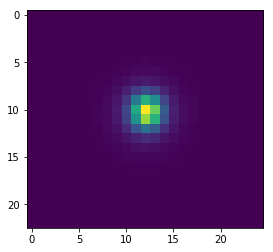

In [18]:
modify_image = test_image.copy()
modify_image = modify_image[1:,:]
plt.imshow(modify_image)
modify_PSFImage = galsim.Image(modify_image)
modify_moments = sxm.get_all_moments(modify_PSFImage, pqlist)
print test_moments
print modify_moments
abs_diff = modify_moments - test_moments
relative_diff = (modify_moments - test_moments)/test_moments
print abs_diff
print relative_diff
results = galsim.hsm.FindAdaptiveMom(modify_PSFImage)
print results

In [248]:
def std_moment_weighted(image, p , q ):
    
    y, x = mgrid[:image.shape[0],:image.shape[1]]+1

    psfresults = galsim.hsm.FindAdaptiveMom(galsim.Image(image, scale = 1.0))
    M = np.zeros((2,2))
    e1 = psfresults.observed_shape.e1
    e2 = psfresults.observed_shape.e2
    sigma4 = psfresults.moments_sigma**4
    c = (1+e1)/(1-e1)
    M[1][1] = np.sqrt(sigma4/(c-0.25*e2*(1+c)**2))
    M[0][0] = c*M[1][1]
    M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
    M[1][0] = M[0][1]
    
#     M[0][0] = (1+psfresults.observed_shape.e1)/2*psfresults.moments_sigma**2
#     M[1][1] = (1-psfresults.observed_shape.e1)/2*psfresults.moments_sigma**2
#     M[1][0] = 0.5*psfresults.observed_shape.e2*psfresults.moments_sigma**2
#     M[0][1] = 0.5*psfresults.observed_shape.e2*psfresults.moments_sigma**2


    
    pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
    pos = np.swapaxes(pos,0,1)
    pos = np.swapaxes(pos,1,2)
    
    
    inv_M = np.linalg.inv(M)
    sqrt_inv_M = alg.sqrtm(inv_M)
    std_pos = np.zeros(pos.shape)
    weight = np.zeros(pos.shape[0:2])
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            this_pos = pos[i][j]
            this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
            std_pos[i][j] = this_standard_pos
            weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))
            #weight[i][j] = np.exp(-0.5* np.matmul(this_pos.T, np.matmul(inv_M,this_pos )))
            
    std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]
    #std_r = np.sqrt(std_x**2+std_y**2)

    #weight = image
    #weight = np.ones(image.shape)
        
    return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    
    
    

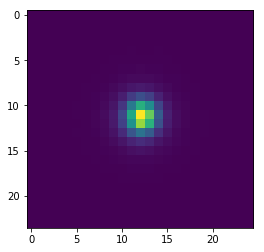

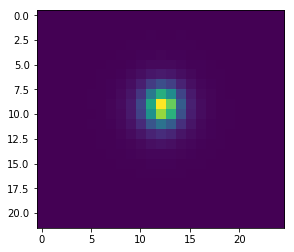

In [266]:
test_image = fits.open(catalog['star_filename'][40])[1].data 
plt.imshow(test_image)
plt.show()
modify_image = fits.open(catalog['star_filename'][40])[1].data[2:, :]
plt.imshow(modify_image)
plt.show()


In [267]:
print std_moment_weighted(test_image, 0,4 )
print std_moment_weighted(modify_image, 0,4 )

0.8048341088332909
0.8048341088324835


In [11]:
blend_flux = catalog['iblendedness_abs_flux']

In [17]:
print np.array(blend_flux[0:200])

[0.00000000e+00 0.00000000e+00 3.92249967e-06 1.08765084e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.83016784e-03
 5.41444667e-12 0.00000000e+00 0.00000000e+00 4.54063957e-06
 2.97856531e-07 0.00000000e+00 1.23129689e-06 1.08093764e-05
 6.29584929e-06 1.65229780e-04 5.79809211e-02 8.17101500e-06
 3.52198128e-07 0.00000000e+00 2.11149654e-05 4.55823601e-06
 2.32600769e-06 4.45675539e-07 0.00000000e+00 1.40273171e-08
 3.70033445e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.74643224e-08 4.40252612e-10 4.02395894e-11 1.74981418e-09
 5.50259938e-06 5.49347057e-08 2.88562183e-06 1.22801595e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.53340770e-05
 9.08019544e-08 7.40961650e-06 0.00000000e+00 1.48317326e-06
 6.09430390e-06 1.70230691e-03 0.00000000e+00 2.78619359e-06
 1.18844063e-08 6.89153865e-07 8.14946645e-07 1.11036422e-06
 3.31338725e-08 6.90965507e-08 6.93285347e-06 3.13096216e-11
 1.41630041e-11 6.47500701e-06 7.68351219e-06 1.96928866e-07
 3.15864636e-05 2.112030